DEC 알고리즘을 대전시 자료를 활용할 수 있도록 수정한 파일
입력자료: 44개 검지기, 1일 16시간, 10분간격, 5주간 입력 자료, 교통량, 속도, 밀도 변수 사용


In [ ]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))


Using TensorFlow backend.


In [2]:
from time import time
import numpy as np
import tensorflow as tf
import keras
#import tensorflow.keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import pandas as pd
import metrics
import warnings
from keras import backend as K

In [3]:
print(keras.__version__)
import warnings
warnings.filterwarnings( 'ignore' )


tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

2.0.5


True

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)
    
    # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:
## 입력자료를 확인하고 input format 수정

trains = np.loadtxt("C:/Users/User/Documents/KOTI/계백로/input_normalize.csv",
                    skiprows=1, delimiter=',', dtype=float)

x = trains[:, 531:795].reshape([len(trains), 264])# 열의 갯수를 수정
#x2 = trains[:, 531:795].reshape([len(trains), 264])
#x = np.concatenate((x1, x2), axis=1)

print(x.shape)

y_year = trains[:, 0].reshape([len(trains)])
y_weekday = trains[:, 1].reshape([len(trains)])
y = trains[:, 2].reshape([len(trains)])

x = x.reshape((x.shape[0], -1))
#x = np.divide(x, 256.)        #normalized 데이터에서는 삭제
#x = np.divide(x, 256.)        #normalized 데이터에서는 삭제
#속도 3-267 교통량 267-531 밀도 531-795 
#1개:264 2개:528 3개:792

(3360, 264)


In [6]:
n_clusters = 5 #len(np.unique(y))  # cluster의 갯수를 직접 선언해야 함
x.shape
print ([y_year, y_weekday, y])

[array([20190818., 20190818., 20190818., ..., 20190921., 20190921.,
       20190921.]), array([1., 1., 1., ..., 7., 7., 7.]), array([ 600.,  610.,  620., ..., 2130., 2140., 2150.])]


In [7]:
#kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
#y_pred_kmeans = kmeans.fit_predict(x)

In [8]:
#metrics.acc(y, y_pred_kmeans)  # 우리 자료에는 label이 없으므로 accuracy를 구할 수 없음

In [9]:
#dims = [x.shape[-1], 500, 500, 2000, 10]
dims = [x.shape[-1], 500, 1000, 2000, 3000, 5000, 10]   # hidden layer를 어떻게 구성할 것인지 고민 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 1000
batch_size = 128
save_dir = './results'

In [10]:
autoencoder, encoder = autoencoder(dims, init=init)

In [11]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 264)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               132500    
_________________________________________________________________
encoder_1 (Dense)            (None, 1000)              501000    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              2002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 3000)              6003000   
_________________________________________________________________
encoder_4 (Dense)            (None, 5000)              15005000  
_________________________________________________________________
encoder_5 (Dense)            (None, 10)                50010     
__________

In [12]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
history = autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/1000




3360/3360 [==============================] - 3s - loss: 0.4184     
Epoch 2/1000
3360/3360 [==============================] - 1s - loss: 0.2156     
Epoch 3/1000
3360/3360 [==============================] - 1s - loss: 0.0219     
Epoch 4/1000
3360/3360 [==============================] - 1s - loss: 0.0157     
Epoch 5/1000
3360/3360 [==============================] - 1s - loss: 0.0155     
Epoch 6/1000
3360/3360 [==============================] - 1s - loss: 0.0154     
Epoch 7/1000
3360/3360 [==============================] - 1s - loss: 0.0154     
Epoch 8/1000
3360/3360 [==============================] - 1s - loss: 0.0154     - ETA: 0s - loss
Epoch 9/1000
3360/3360 [==============================] - 1s - loss: 0.0154     
Epoch 10/1000
3360/3360 [==============================] - 1s - loss: 0.0154     - ETA: 1
Epoch 11/1000
3360/3360 [===============

3360/3360 [==============================] - 1s - loss: 0.0079     - ETA: 0s - los
Epoch 167/1000
3360/3360 [==============================] - 1s - loss: 0.0078     
Epoch 168/1000
3360/3360 [==============================] - 1s - loss: 0.0078     
Epoch 169/1000
3360/3360 [==============================] - 1s - loss: 0.0078     
Epoch 170/1000
3360/3360 [==============================] - 1s - loss: 0.0078     
Epoch 171/1000
3360/3360 [==============================] - 1s - loss: 0.0077     
Epoch 172/1000
3360/3360 [==============================] - 1s - loss: 0.0077     
Epoch 173/1000
3360/3360 [==============================] - 1s - loss: 0.0077     - ETA: 0s - los
Epoch 174/1000
3360/3360 [==============================] - 1s - loss: 0.0077     
Epoch 175/1000
3360/3360 [==============================] - 1s - loss: 0.0076     
Epoch 176/1000
3360/3360 [==============================] - 1s - loss: 0.0076     
Epoch 177/1000
3360/3360 [==============================] - 1s - loss: 0

3360/3360 [==============================] - 1s - loss: 0.0058     - ETA: 0s - loss:
Epoch 352/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 353/1000
3360/3360 [==============================] - 1s - loss: 0.0058     - ETA: 1s
Epoch 354/1000
3360/3360 [==============================] - 1s - loss: 0.0058     - ETA: 
Epoch 355/1000
3360/3360 [==============================] - 1s - loss: 0.0058     - ETA: 1
Epoch 356/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 357/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 358/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 359/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 360/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 361/1000
3360/3360 [==============================] - 1s - loss: 0.0058     
Epoch 362/1000
3360/3360 [==============================] - 1

3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 536/1000
3360/3360 [==============================] - 1s - loss: 0.0055     - ETA: 0s - los
Epoch 537/1000
3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 538/1000
3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 539/1000
3360/3360 [==============================] - ETA: 0s - loss: 0.005 - 1s - loss: 0.0055     
Epoch 540/1000
3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 541/1000
3360/3360 [==============================] - 1s - loss: 0.0055     - ETA: 0s - loss: 0.0
Epoch 542/1000
3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 543/1000
3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 544/1000
3360/3360 [==============================] - 1s - loss: 0.0055     
Epoch 545/1000
3360/3360 [==============================] - 1s - loss: 0.0055     - ETA: 1s 
Epoch 546/1000
3360/3360 [======

3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 719/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 720/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 721/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 722/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 723/1000
3360/3360 [==============================] - 1s - loss: 0.0053     - ETA: 0s - los
Epoch 724/1000
3360/3360 [==============================] - 1s - loss: 0.0053     - ETA: 0s - loss: 
Epoch 725/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 726/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 727/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 728/1000
3360/3360 [==============================] - 1s - loss: 0.0053     
Epoch 729/1000
3360/3360 [==============================] - 1s - loss

3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 903/1000
3360/3360 [==============================] - ETA: 0s - loss: 0.005 - 1s - loss: 0.0052     
Epoch 904/1000
3360/3360 [==============================] - ETA: 0s - loss: 0.005 - 1s - loss: 0.0052     
Epoch 905/1000
3360/3360 [==============================] - 1s - loss: 0.0052     - ETA: 0s
Epoch 906/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 907/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 908/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 909/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 910/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 911/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 912/1000
3360/3360 [==============================] - 1s - loss: 0.0052     
Epoch 913/1000
3360/3360 [===================

In [13]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc =0)

plot_loss(history)
plt.show()

<Figure size 640x480 with 1 Axes>

(3360, 264) (3360, 264)


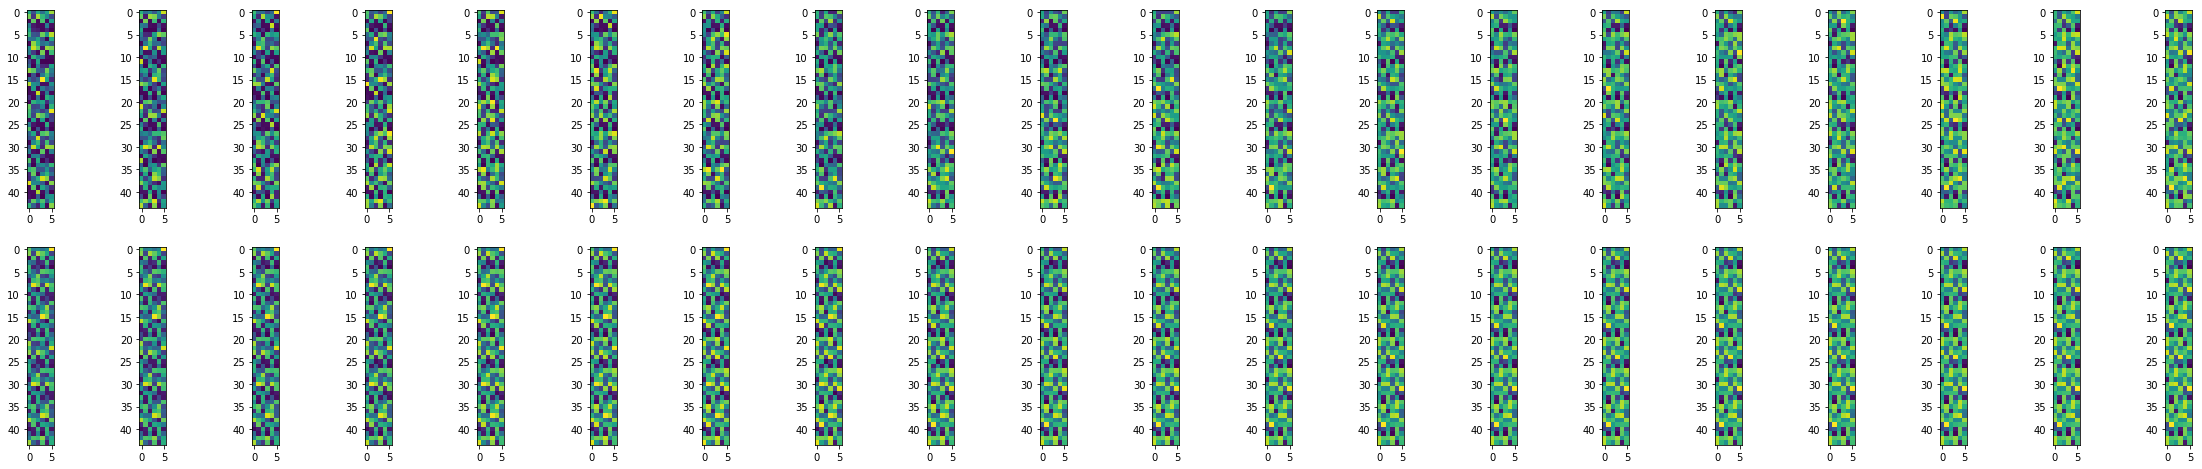

In [14]:
decoded_images = autoencoder.predict(x)

print(decoded_images.shape, x.shape)
N, n_i = x.shape
x1 = x.reshape(N, 44, -1)
decoded_images = decoded_images.reshape(N, 44, -1)

n = 20
plt.figure(figsize=(40,8))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x1[i])
    
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_images[i])
    
plt.show()

In [15]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [16]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape = (self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
clustering_layer = ClusteringLayer(n_clusters, name ='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 20000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

Instructions for updating:
keep_dims is deprecated, use keepdims instead




In [18]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Iter 0: acc = 0.05060, nmi = 0.40075, ari = 0.02997  ; loss= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 140: acc = 0.05060, nmi = 0.40574, ari = 0.03396  ; loss= 0.07165
Iter 280: acc = 0.05060, nmi = 0.40765, ari = 0.02763  ; loss= 0.11553
Iter 420: acc = 0.05060, nmi = 0.41462, ari = 0.03332  ; loss= 0.08971
Iter 560: acc = 0.05060, nmi = 0.42799, ari = 0.03551  ; loss= 0.17542
Iter 700: acc = 0.05060, nmi = 0.43083, ari = 0.03639  ; loss= 0.09088
Iter 840: acc = 0.05060, nmi = 0.42852, ari = 0.03759  ; loss= 0.11985
Iter 980: acc = 0.05060, nmi = 0.41871, ari = 0.03859  ; loss= 0.13719
Iter 1120: acc = 0.04911, nmi = 0.41122, ari = 0.03523  ; loss= 0.16947
Iter 1260: acc = 0.04911, nmi = 0.40877, ari = 0.03334  ; loss= 0.33065
Iter 1400: acc = 0.04851, nmi = 0.40714, ari = 0.03343  ; loss= 0.04679
Iter 1540: acc = 0.04911, nmi = 0.41304, ari = 0.03280  ; loss= 0.12881
Iter 1680: acc = 0.04881, nmi = 0.40821, ari = 0.03389  ; 

In [19]:
model.load_weights(save_dir + '/DEC_model_final.h5')

In [20]:
# Eval.
############ redefine test data set ##############

trains = np.loadtxt("C:/Users/User/Documents/KOTI/계백로/input_normalize.csv",
                    skiprows=1, delimiter=',', dtype=float)

test = np.loadtxt("C:/Users/User/Documents/KOTI/계백로/input_normalize.csv", skiprows=1, delimiter=',', dtype=float)
x = test[:, 531:795].reshape([len(trains), 264])
#x1 = test[:, 3:267].reshape([len(test), 264])  # 열의 갯수를 수정
#x2 = test[:, 531:795].reshape([len(test), 264])
#x = np.concatenate((x1, x2), axis=1)
#속도 3-267 교통량 267-531 밀도 531-795 
#1개:264 2개:528 3개:792
y_year = test[:, 0].reshape([len(test)])
y_weekday = test[:, 1].reshape([len(test)])
y = test[:, 2].reshape([len(test)])

x = x.reshape((x.shape[0], -1))
#x = np.divide(x, 255.)    #normalized 데이터에서는 삭제


q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.05000, nmi = 0.41000, ari = 0.03627  ; loss= 0.04985


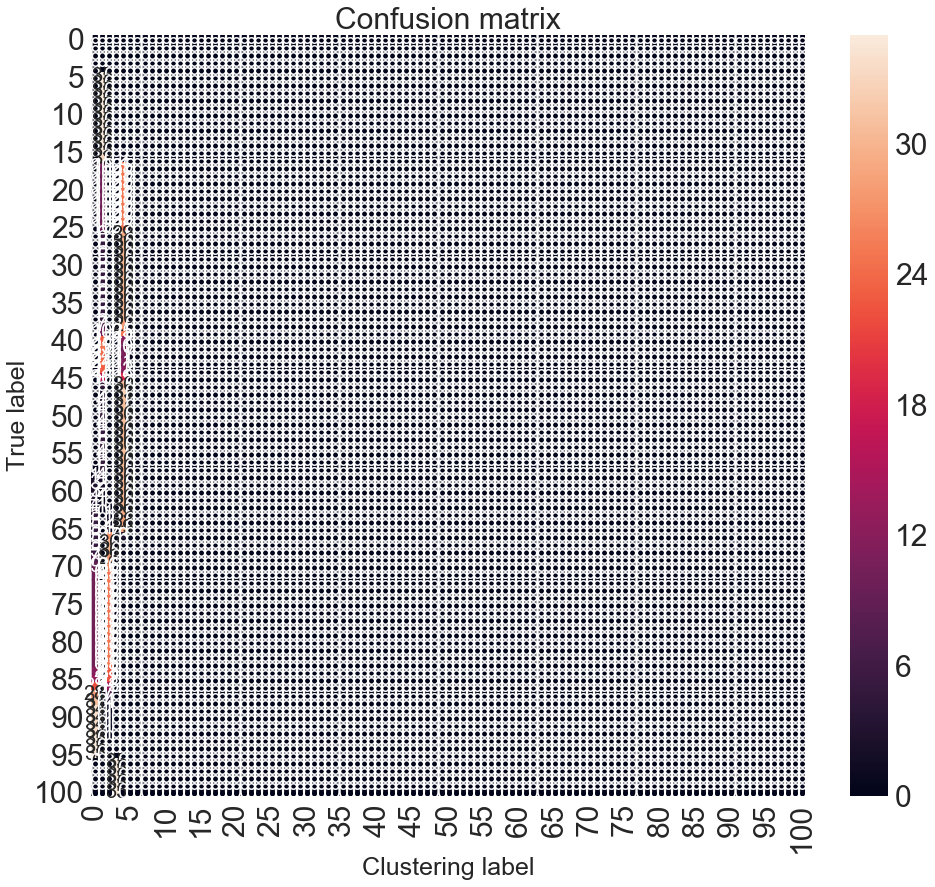

In [21]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [22]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

0.05

In [23]:
y_pred = y_pred.reshape(-1, 1)
y = y.reshape(-1, 1)

df = pd.DataFrame(y_year, columns = ['year'])
df['weekday'] = y_weekday
df['true'] = y
df['cluster_id'] = y_pred
df.to_excel('C:/Users/User/Documents/KOTI/계백로/results/result.xlsx', index = False )